In [1]:
# Load Packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import keras.models

import model_prep

datapath = "../data"

2023-06-12 16:11:16.991694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
step_back = 6
step_forward = 1

<h2 style="color:#27469c">1. Preprocess ESB Tower 2 data</h2>

In [3]:
df = pd.read_csv(f'{datapath}/esb/esb_tower_2_preprocessed.csv', index_col='time')
df.index = pd.to_datetime(df.index)

print(f"Summer data makes up {df[df['ESB_Tower_2 season']=='summer'].shape[0] / df.shape[0] * 100}% of the data throughout the year.")
df = df[df['ESB_Tower_2 season']=='summer']
print(f"Of the summer data, cooling tower was on {df[df['Cell_2aFan fanOnOff'] | df['Cell_2bFan fanOnOff']].shape[0] / df.shape[0] * 100}% of the time")

# set features and targets
features = ['ESB_Tower_2 enteringWaterTemp', 'ESB_Tower_2 outdoorAirHumidity', 'ESB_Tower_2 outdoorAirDryBulb', 'ESB_Tower_2 outdoorAirWetBulb', 'Cell_2aFan vfdPower', 'Cell_2bFan vfdPower']
targets = ['ESB_Tower_2 leavingWaterTemp']

# save a boolean series that specifies whether the cooling tower is on
on_condition = df['Cell_2aFan fanOnOff'] | df['Cell_2bFan fanOnOff']
# create final dataframe that includes only relevant features and targets
df = df[features].join(df[targets], on=df.index)

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
df = pd.DataFrame(scaler.fit_transform(df.values.astype('float32')), columns=df.columns, index=df.index)

lstm_df = model_prep.create_timesteps(df, n_in=step_back, n_out=step_forward, target_names=targets)
print(f"Number of samples in summer data before removing off times: {lstm_df.shape[0]}")
lstm_df = lstm_df[on_condition]
print(f"Number of samples in summer data after removing off times: {lstm_df.shape[0]}")
lstm_df.to_csv(f"{datapath}/esb/esb2_winter_timestepped.csv")

Summer data makes up 24.796837883844162% of the data throughout the year.
Of the summer data, cooling tower was on 43.93034439962767% of the time
Number of samples in summer data before removing off times: 25784
Number of samples in summer data after removing off times: 11327


<h2 style="color:#27469c">2. Convert ESB Tower 2 data into model-compatible shape</h2>

In [4]:
tss = TimeSeriesSplit(n_splits = 3)
X = lstm_df.drop([f'{target}(t)' for target in targets], axis=1) # drop target columns
y = lstm_df[[f'{target}(t)' for target in targets]] # only have target columns

vec_X_test = model_prep.df_to_3d(lstm_datadf=X, num_columns=len(features)+1, step_back=step_back)
vec_y_test = y.values

print(vec_X_test.shape, vec_y_test.shape)

(11327, 6, 7) (11327, 1)


<h2 style="color:#27469c">3. Load model and predict</h2>

In [5]:
model = keras.models.load_model('../models_saved/esb1_summer_lstm')

2023-06-12 16:11:20.603253: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


354/354 [==============================] - 1s 1ms/step


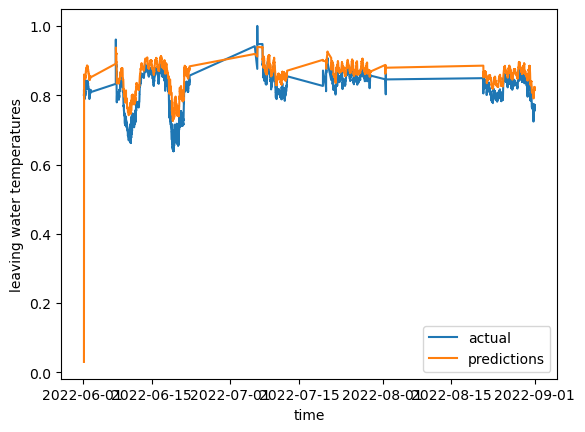

Mean Absolute Error: 0.036
RMSE: 0.042


In [6]:
yhat = model.predict(vec_X_test)

mabs_error = mean_absolute_error(vec_y_test, yhat)
rmse = np.sqrt(mean_squared_error(vec_y_test, yhat))

# Plot the lines using Matplotlib
plt.plot(y.index, vec_y_test, label='actual', color='C0')
plt.plot(y.index, yhat, label='predictions', color='C1')

# Add labels and legend
plt.xlabel('time')
plt.ylabel('leaving water temperatures')
plt.legend()

# Show the plot
plt.show()

print('Mean Absolute Error: %.3f' % mabs_error)
print('RMSE: %.3f' % rmse)